# Icatibant lot 23 decomposition

This notebook shows how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition


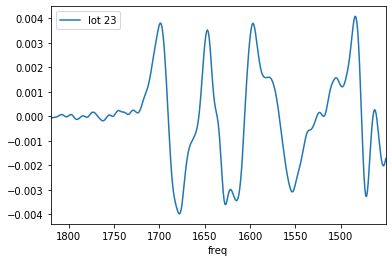

In [4]:
# imports
%matplotlib inline
import os
import pandas as pd
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990
from ftir.io.utils import create_df_from_single_file

# get the data
os.getcwd()
raw_data_filename = os.path.abspath("./20191009_nsm_Icatibant/2Der/23_0 2Der.txt")
rawData_df = pd.read_csv(raw_data_filename, header=None)
rawData_df.rename(columns={0: "freq", 1: "lot 23"}, inplace=True)
sample_names = list(rawData_df.columns)[1:]
rawData_df[(rawData_df['freq'] > 1450) & (rawData_df['freq'] < 1820)].plot.line(x='freq', y='lot 23').invert_xaxis()

## Baseline correction

Rubberband baseline correction was done, and the spectra was flipped over the y-axis. The spectra was also nearred to focus only on the amide I region.

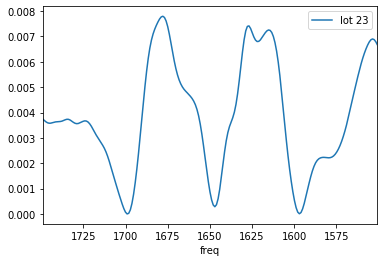

In [6]:
corrected_df = sd_baseline_correction(rawData_df, cols=['lot 23'], flip=True, method='min', bounds=(1750, 1550))
corrected_df.plot.line(x='freq', y='lot 23').invert_xaxis()

Analyzing lot 23


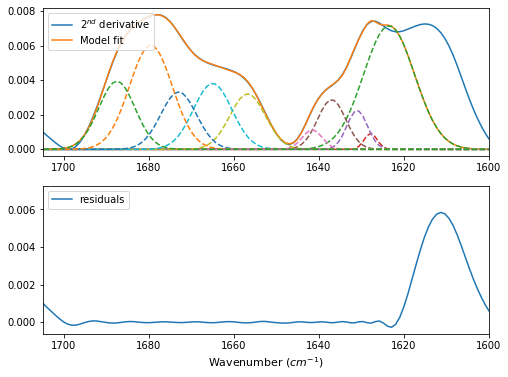

{'beta_sheet_and_extended_chain': 0.03520818940934722, 'alpha_helix': 0.0004892734245967483, 'unordered': 0.017220000941019747, 'beta_sheet': 0.34979310235072913, 'turn': 0.48797435096481634}


In [7]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=1.5, 
                                   peaks=yang_h20_2015, params={'loss':'linear'})
structs = secondary_structure(area, yang_h20_2015)
gaussian_list_data = gaussian_list(corrected_df['freq'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)

## Poor peak fitting

Poor fitting was observed below 1620, as there is an apparent peak in the data. This is likely a side-chain peak, as several synthetic peptides are used in icatibant. Thus an additional peak was added to the peak definition in order to capture this feature. The peak initial guess was centered around 1610 wavenumbers and had a relatively large uncertainity of 4.

In [9]:
from copy import deepcopy
new_peaks = deepcopy(yang_h20_2015)
new_peaks['means'].append(1610)
new_peaks['assignments'].append('side-chain')
new_peaks['uncertainties'].append((1606, 1616))
new_peaks['relative_uncertainties'].append(4)

Analyzing lot 23


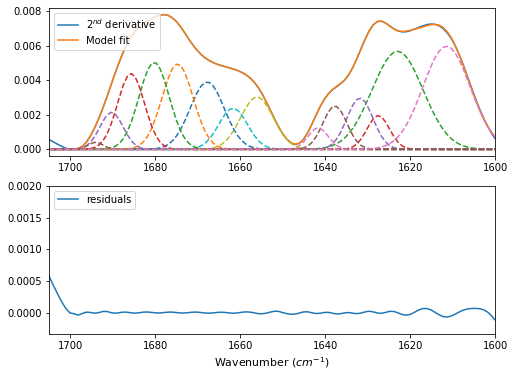

{'alpha_helix': 0.06364388854120384, 'beta_turn': 0.3571541388338512, 'side-chain': 0.18112849695227246, 'beta_sheet': 0.35419047445800217, 'unordered': 5.726837740437527e-05, '310_helix': 0.04382573283726587}


In [7]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=1.5, peaks=new_peaks)
structs = secondary_structure(area, new_peaks)
gaussian_list_data = gaussian_list(corrected_df['freq'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)